# TESTING THE PERFROMANCE OF THE TRAINED MODELS

## 1. IMPORT THE RELEVANT LIBRARIES

Please have a look at the **requirements.txt** file for the prerequisite libraries and their versions.<br>
Within the **Module** folder, I have created separate files for the model architectures which were used in **Joint_Training_WGAN** notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics.functional as Fm

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import math

from Module.Generator import Generator_Net, Mask_Generator_Net

## 2. SET HYPERPARAMETERS

1. device: To choose cuda GPU as the execution device in case it is available.
2. data_dir: The path to the root folder of the **CELEBA HQ Facial identity dataset**
3. batch_size: Size of test dataset batch
4. num_workers: Number of dataloader workers
5. density: Desired Mask Density. **Set it to the same value as used in Training**.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
data_dir = '.\\CelebA_HQ_facial_identity_dataset'
batch_size = 32
num_workers = 2
density = 0.05

## 3.LOADING TEST DATASET

In [3]:
transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## 4. CALCULATING THE METRICS

* Two models were trained. These models are saved in the **DLVC_BestModels** folder.
 1. **Full_model**: Joint training of Mask Network(5% selected pixels) + Inpainting Generator + Discriminator
 2. **No_Mask**: Mask sampled from uniform random distribution(5% selected pixels) + Inpainting Generator + Discriminator


* The performance is tested over 3 metrics namely: 
 1. Mean Squared Error(**MSE**),
 2. Peak Signal to Noise Ratio(**PSNR**),
 3. Structural Similarity Index Measure(**SSIM**)
 
**Test Scenario Description:**
1. *Joint training*: Jointly trained full model with Mask network, Inpainting generator network and discriminator.
2. *No Mask N/w(5%)*: Only Inpainting generator network and discriminator. 5% of the pixels randomly selected.
3. *Joint trained Generator N/w(5%)*: Only the inpainting generator network trained jointly is used. 5% of the pixels randomly selected.
4. *No Mask N/w(6.24%)*: Only Inpainting generator network and discriminator. 6.24% of the pixels randomly selected.
5. *Joint trained Generator N/w(6.24%)*: Only the inpainting generator network trained jointly is used. 6.24% of the pixels randomly selected.

**Please read the next section for why these 5 scenarios were selected**
 
Since the use of random seeds(in both models) and random masks(No mask network case) introduce stochasticity, the testing was repeated 10 times for each scenario and the mean and standard deviation for all metrics are calculated.

In [4]:
test_scenarios = ["Joint training", "No Mask Network", "No Mask Network(6.24%)", "Joint trained Generator N/w(5%)", "Joint trained Generator N/w(6.24%)"]
model_folder = ["Full_Training", "No_Mask", "No_Mask", "Full_Training", "Full_Training"]
load_mask_G = [True, False, False, False, False]
densities = [0.05, 0.05, 0.0624, 0.05, 0.0624]

base_dir = ".\\DLVC_BestModels"

In [5]:
metrics = {}

for t in range(len(test_scenarios)):
    print(test_scenarios[t])
    print("Selected Pixel Density:"+ str(densities[t]))
    metrics[t] = {}
    
    model_path = os.path.join(base_dir, model_folder[t])
    print("Models loaded from path: "+str(model_path))

    G = Generator_Net(7).cuda()
    G.load_state_dict(torch.load(os.path.join(model_path,"model_G.pth")))
    G.eval()
    print("Generator loaded")

    if load_mask_G[t]:
        mask_G = Mask_Generator_Net(6).cuda()
        mask_G.load_state_dict(torch.load(os.path.join(model_path,"model_mask_G.pth")))
        mask_G.eval()
        print("Mask network loaded")
    else:
        print("Randomly selected masks")


    mse_list = []
    SSIM_list = []
    PSNR_list = []
    pixels_list = []

    for i in range(10):
        avg_mse = 0.0
        avg_SSIM = 0.0
        avg_pixels = 0.0
        entries = 0
        with torch.no_grad():
            for data, labels in test_dataloader:
                data = data.cuda()
                if load_mask_G[t]:
                    img_masks = mask_G(torch.cat((data, torch.normal(0.0,0.1,size=data.size()).cuda()), 1))
                else:
                    B,C,H,W = data.shape
                    img_masks = ((torch.rand(B,1,H,W)<=densities[t])*1.0).cuda()

                #print("Mask generated")
                # ============== Create Masked Video ============== #

                masked_imgs = img_masks * data

                # ============== Frame Generator ================= #

                fake_imgs = G(torch.cat((masked_imgs, img_masks, torch.normal(0.0,0.1,size=data.size()).cuda()), 1))
                avg_pixels += torch.sum(img_masks).item()/(128*128)
                avg_mse += data.shape[0]*F.mse_loss(data, fake_imgs).item()
                avg_SSIM += data.shape[0]*Fm.structural_similarity_index_measure(fake_imgs, data).item()
                entries += data.shape[0]
        avg_mse /= entries
        avg_SSIM /= entries
        avg_pixels /= entries
        
        PSNR = 10*math.log(1/avg_mse,10)
        mse_list.append(avg_mse)
        SSIM_list.append(avg_SSIM)
        PSNR_list.append(PSNR)
        pixels_list.append(avg_pixels)
    metrics[t]["Pixels"] = [np.mean(pixels_list), np.std(pixels_list)]
    metrics[t]["MSE"] = [np.mean(mse_list), np.std(mse_list)]
    metrics[t]["PSNR"] = [np.mean(PSNR_list), np.std(PSNR_list)]
    metrics[t]["SSIM"] = [np.mean(SSIM_list), np.std(SSIM_list)]

Joint training
Selected Pixel Density:0.05
Models loaded from path: .\DLVC_BestModels\Full_Training
Generator loaded
Mask network loaded
No Mask Network
Selected Pixel Density:0.05
Models loaded from path: .\DLVC_BestModels\No_Mask
Generator loaded
Randomly selected masks
No Mask Network(6.24%)
Selected Pixel Density:0.0624
Models loaded from path: .\DLVC_BestModels\No_Mask
Generator loaded
Randomly selected masks
Joint trained Generator N/w(5%)
Selected Pixel Density:0.05
Models loaded from path: .\DLVC_BestModels\Full_Training
Generator loaded
Randomly selected masks
Joint trained Generator N/w(6.24%)
Selected Pixel Density:0.0624
Models loaded from path: .\DLVC_BestModels\Full_Training
Generator loaded
Randomly selected masks


In [6]:
for t in range(len(test_scenarios)):
    print(test_scenarios[t])
    print("Selected Pixels: "+"{:.2f}% ".format(metrics[t]["Pixels"][0]*100)+u"\u00B1"+" {:.6f}".format(metrics[t]["Pixels"][1]))
    print("MSE: "+"{:.6f} ".format(metrics[t]["MSE"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["MSE"][1]))
    print("PSNR: "+"{:.6f} ".format(metrics[t]["PSNR"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["PSNR"][1]))
    print("SSIM: "+"{:.6f} ".format(metrics[t]["SSIM"][0])+u"\u00B1"+" {:.6f}".format(metrics[t]["SSIM"][1]))

Joint training
Selected Pixels: 6.24% ± 0.000029
MSE: 0.003886 ± 0.000004
PSNR: 24.104510 ± 0.004701
SSIM: 0.747958 ± 0.000109
No Mask Network
Selected Pixels: 5.00% ± 0.000050
MSE: 0.004359 ± 0.000009
PSNR: 23.606445 ± 0.009111
SSIM: 0.736153 ± 0.000209
No Mask Network(6.24%)
Selected Pixels: 6.24% ± 0.000072
MSE: 0.003835 ± 0.000011
PSNR: 24.162176 ± 0.011900
SSIM: 0.753369 ± 0.000258
Joint trained Generator N/w(5%)
Selected Pixels: 5.00% ± 0.000049
MSE: 0.007087 ± 0.000020
PSNR: 21.495511 ± 0.012124
SSIM: 0.628223 ± 0.000301
Joint trained Generator N/w(6.24%)
Selected Pixels: 6.24% ± 0.000073
MSE: 0.006370 ± 0.000007
PSNR: 21.958878 ± 0.004924
SSIM: 0.647333 ± 0.000253


## 5. RESULTS: METRICS

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | <ins>0.003886 ± 0.000004</ins> | <ins>24.104510 ± 0.004701</ins> | <ins>0.747958 ± 0.000109</ins> | 6.24% ± 0.000029 |
| **No Mask N/w(5%)** | 0.004359 ± 0.000009 | 23.606445 ± 0.009111 | 0.736153 ± 0.000209 | <ins>5.00% ± 0.000050</ins> |
| **Joint trained Generator N/w(5%)** | 0.007087 ± 0.000020 | 21.495511 ± 0.012124 | 0.628223 ± 0.000301 | 5.00% ± 0.000049 |


**NOTE**: Due to the stochasticity introduced by random seeds/masks, the calculated metrics are subject to change. But they are believed to be close to the reported values.

### INFERENCES

**The following are the inferences for the CELEB A HQ Facial Identity dataset. Performance might vary for different datasets.**

* *Full model shows a better performance than the model with no mask network in all metrics*. But it also seems to select approximately 1.24%(6.24%-5.00%) of the total pixels additionally. To make both the models even, 6.24% of the pixels were selected during testing for the "*No Mask N/w*" case originally trained over 5% of the pixels.

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | 0.003886 ± 0.000004 | 24.104510 ± 0.004701 | 0.747958 ± 0.000109 | 6.24% ± 0.000029 |
| **No Mask N/w(6.24%)** | <ins>0.003835 ± 0.000011</ins> | <ins>24.162176 ± 0.011900</ins> | <ins>0.753369 ± 0.000258</ins> | 6.24% ± 0.000072 |

* This shows that both models show comparable performance with the No Mask N/w model performing better by a very small margin. The <ins>hyperparameters used for the training were the same for both the models</ins>. *This might call into question the need for training the additional mask network*. Note that maybe tuning the parameters for individual cases might alter the results.

* From the first table, it is clear that a *tight coupling exists between the mask generator and inpainting generator*. There is a significant deterioration in performance when the mask network is replaced by 5% randomly generated masks. To be fair to the generator I also tested the 6.24% of pixels selected case. It doesn't change the inference.

| Test Scenario | MSE<br>(Lower is better) | PSNR<br>(Higher is better) | SSIM<br>(Higher is better) | Selected Pixels |
| :-: | :-: | :-: | :-: | :-: |
| **Joint training** | <ins>0.003886 ± 0.000004</ins> | <ins>24.104510 ± 0.004701</ins> | <ins>0.747958 ± 0.000109</ins> | 6.24% ± 0.000029 |
| **Joint trained Generator N/w(5%)** | 0.007087 ± 0.000020 | 21.495511 ± 0.012124 | 0.628223 ± 0.000301 | 5.00% ± 0.000049 |
| **Joint trained Generator N/w(6.24%)** | 0.006370 ± 0.000007 | 21.958878 ± 0.004924 | 0.647333 ± 0.000253 | 6.24% ± 0.000073 |

## 6. VISUAL EXAMPLES OF THE JOINTLY TRAINED MODEL

Executing the following two cells selects a random test image and shows the real and reconstructed image along with the mask and masked image

In [74]:
from torchvision.transforms import ToPILImage
import random

model_path = ".\\DLVC_BestModels\\Full_Training"

G = Generator_Net(7).cuda()
G.load_state_dict(torch.load(os.path.join(model_path,"model_G.pth")))
G.eval()
mask_G = Mask_Generator_Net(6).cuda()
mask_G.load_state_dict(torch.load(os.path.join(model_path,"model_mask_G.pth")))
mask_G.eval()

random_idx = random.randint(0,len(test_dataset))
data,_ = test_dataset[random_idx]
C,H,W = data.shape
data = data.view(1,C,H,W).to(device)
img_masks = mask_G(torch.cat((data, torch.normal(0.0,0.1,size=data.size()).cuda()), 1))
chosen_pixels = torch.sum(img_masks).item()
masked_imgs = img_masks * data
fake_imgs = G(torch.cat((masked_imgs, img_masks, torch.normal(0.0,0.1,size=data.size()).cuda()), 1))

convert_to_img = ToPILImage()
data = convert_to_img(data.view(3,H,W))
img_masks = convert_to_img(img_masks.view(1,H,W))
masked_imgs = convert_to_img(masked_imgs.view(3,H,W))
fake_imgs = convert_to_img(fake_imgs.view(3,H,W))

Text(0.5, 1.0, 'Reconstructed Image')

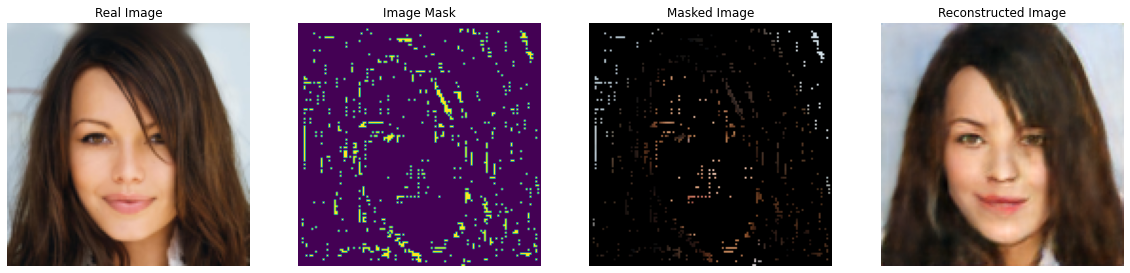

In [75]:
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(20, 12))
  
# setting values to rows and column variables
rows = 1
columns = 4
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(data)
plt.axis('off')
plt.title("Real Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img_masks)
plt.axis('off')
plt.title("Image Mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(masked_imgs)
plt.axis('off')
plt.title("Masked Image")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(fake_imgs)
plt.axis('off')
plt.title("Reconstructed Image")

print("Chosen pixels: "+str(chosen_pixels))

## 7. RELEVANCE OF THE METHODS TO FINE-GRAINED DATA DISTRIBUTIONS:

From the examples shown in the [A WASSERSTEIN GAN FOR JOINT LEARNING
OF INPAINTING AND ITS SPATIAL OPTIMISATION
](https://arxiv.org/pdf/2202.05623.pdf), we can infer that the Joint Training methodology does a good job with reconstruction of general distributions. But in fine-grained datasets like CELEB A HQ facial identity dataset, **it is important that the reconstruction belongs to the distribution of the real image**. To put it simply, the faces in the real and reconstructed image must belong to the same person. **But this might not be the case** as shown in the image below. Though there are some similarities, they look like different people. <br>
![](.\\Test_images\\real1.png)
![](.\\Test_images\\real2.png)

One possible solution to this problem would be to use **conditional GANs** that additionally take the modality information and tailor the GAN performance accordingly. But this **introduces the additional task of identifying the modality** of the real image.

## 8. OUT-OF-DISTRIBUTION PERFORMANCE

There are two ways to compress images using Deep Neural Networks.
1. Autoencoder-Decoder networks with bottleneck embeddings as the compressed form,
2. Sparse pixel selection with mask/selected pixels as the compressed form.

My **preliminary views** on the application of both these methods for image compression were as follows.
* For the Autoencoder-Decoder networks, the task at hand is to **learn the latent distribution of given images**. Autoencoder networks achieve a better compressions rate of both for a fixed distribution of decent size. But to fit a very large distribution we need to scale the size of the embedding accordingly. Otherwise, the performance suffers due to underfitting.
* Sparse pixel selection methods don't try to learn the image distribution and instead **learn the task of choosing relevant pixels along the high frequent regions(edges)**. The task for the inpainting generator network would then be to **colour missing pixels according to the boundary pixels**. This task would be much more scalable as it is **independent of input distributions**.

The way I visualized the above scenario is:<br>
**Goal:** paint a picture.<br>
> **Autoencoder-Decoder:** Given a description of the picture(some sort of embedding), draw it from memory.<br>
> **Sparse pixel selection:** Given a colouring book with bounded regions and colours at each boundary, fill the regions.<br>

The examples in the paper show how relevant pixels are chosen on the edges and inpainting takes care of the colour filling. I wanted to see if my assumptions about sparse pixel selection methods are correct and that the inpainting generator network learns the colouring task and does not memorize the input distribution in any way. To this extent, I used the model learned on CELEB A HQ facial dataset and applied it to a few images from **PARIS Street view dataset(no faces in them)**. The results are as follows:

![](.\\Test_images\\Paris_1.png)
![](.\\Test_images\\Paris_2.png)
![](.\\Test_images\\Paris_3.png)

If we look closely, we faintly notice faces in the reconstructed images. That means that the **inpainting generator network is learning the input image distribution rather than just colouring**. This raises questions about the scalability of Sparse pixel selection methods.